In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as scs
from IPython.core.display import display, HTML, Latex, Markdown

# Add imports
import json
import requests
import os
from time import sleep

# Set the visualization settings
matplotlib.rcParams['axes.titlesize'] = 'xx-large'
matplotlib.rcParams['axes.labelsize'] = 'x-large'
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

# Load the data & process

In [2]:
# All the filtered de novo variants
de_novos_annotated_filtered = pd.read_csv("../data/Kaplanis_et_al_de_novos_annotated_filtered.csv")

KaplanisSupTable2 = pd.read_csv('../data/external/Kaplanis_et_al_Nature2020_Supplementary_Table_2.csv', sep='\t')
discordant_known_genes = KaplanisSupTable2[KaplanisSupTable2.diagnostic_category == 'discordant']
consensus_known_genes = KaplanisSupTable2[KaplanisSupTable2.diagnostic_category == 'consensus']
novel_genes = KaplanisSupTable2[KaplanisSupTable2.diagnostic_category == 'novel']


# Check if the number of genes are correctly loaded
assert len(discordant_known_genes) == 602
assert len(consensus_known_genes) == 380
assert len(novel_genes) == 28
assert len([x for x in list(novel_genes.symbol) if x in list(consensus_known_genes.symbol)]) == 0
assert len([x for x in list(novel_genes.symbol) if x in list(discordant_known_genes.symbol)]) == 0
assert len([x for x in list(discordant_known_genes.symbol) if x in list(consensus_known_genes.symbol)]) == 0
assert len([x for x in list(consensus_known_genes.symbol) if x in list(discordant_known_genes.symbol)]) == 0

# Annotated positions of de novo mutations with meta-domain positions
variants_with_metadomain_annotation_filename= '../data/Kaplanis_et_al_de_novos_with_metadomain_annotation.csv'

exists = os.path.isfile(variants_with_metadomain_annotation_filename)
if exists:
    # Load the previously created file
    print("Found file: loading previous reannotation of metadomain information")
    variants_with_metadomain_annotation_df = pd.read_csv(variants_with_metadomain_annotation_filename)
else:
    raise Exception("File not found for metadomain annotated variants: "+str(variants_with_metadomain_annotation_filename))

# Annotated positions of de novo mutations with meta-domain positions
metadomain_details_filename= '../data/metadomain_details.ALL'

exists = os.path.isfile(metadomain_details_filename)
if exists:
    # Load the previously created file
    print("Found file: loading previous metadomain_details")
    metadomain_details_df = pd.read_csv(metadomain_details_filename)
else:
    raise Exception("File not found for metadomain details: "+str(metadomain_details_filename))

Found file: loading previous reannotation of metadomain information
Found file: loading previous metadomain_details


In [3]:
# Retrieve the variants that are occurrung in protein domains
de_novo_variants_in_domain = pd.DataFrame(de_novos_annotated_filtered[de_novos_annotated_filtered.ext_db_id == de_novos_annotated_filtered.ext_db_id])

# Add unique identifier
de_novo_variants_in_domain['domain_region_id'] = de_novo_variants_in_domain.apply(lambda row: str(row.symbol) + '-' + str(row.ext_db_id) + ':' + str(int(row.pfam_start)) + '_' + str(int(row.pfam_stop)), axis=1)
variants_with_metadomain_annotation_df['domain_region_id'] = variants_with_metadomain_annotation_df.apply(lambda row: str(row.symbol) + '-' + str(row.ext_db_id) + ':' + str(int(row.pfam_start)) + '_' + str(int(row.pfam_stop)), axis=1)

# Method definitions

In [4]:
def MetaDomainHotSpotScoring(x, N, L):
    probability = (1- scs.binom.cdf(x-1, N, 1/L)**L)
    p_value = scs.binom_test(x-1, N, 1/L)
    m_cluster_score = -np.log10(probability)
    return p_value, probability, m_cluster_score

In [5]:
def compute_hotspots_for_domain(hotspot_candidates, N, L, hotspot_type):
    results = []

    # Set the adjustable N and L
    N_adjusted = N
    L_adjusted = L
    
    # Iteration counter needed for the step down approach
    iteration_counter = 0
    
    # Value for checking that we are actually using a step down approach
    previous_hotspot_size = None
    
    # Compute both a step-down and general hotspot ranking 
    # for the biggest cluster in a domain (or biggest clusters if there are multiple clusters of the same size),
    # n is equal to n0, the total number of mutations in the domain and L is equal to L0, 
    # the total number of positions.
    for k_hotspot_size, hot_spot_candidates in hotspot_candidates.sort_values(hotspot_type, ascending=False).groupby(hotspot_type, sort=False):

        # double check we are counting down the hotspot sizes
        if previous_hotspot_size is None:
            previous_hotspot_size = k_hotspot_size
        else:
            assert k_hotspot_size < previous_hotspot_size
            previous_hotspot_size = k_hotspot_size
        
        # Perform the mClustering method
        for index, row in hot_spot_candidates.iterrows():
            result = row.to_dict()
            result['N_adjusted'] = N_adjusted
            result['L_adjusted'] = L_adjusted
            result['p_value_step_down'], result['probability_step_down'], result['mCluster_step_down'] = MetaDomainHotSpotScoring(row[hotspot_type], N_adjusted, L_adjusted)
            result['p_value'], result['probability'], result['mCluster_DSScore'] = MetaDomainHotSpotScoring(row[hotspot_type], N, L)
            results.append(result)

        # n is equal to n0 minus the total number of mutations observed in the previously considered clusters
        # L is equal to L0 minus the number of previously considered positions. 
        N_adjusted -= k_hotspot_size*len(hot_spot_candidates)
        L_adjusted -= len(hot_spot_candidates)
        iteration_counter += 1
        
    return results

def compute_hotspots_over_dataset(df, metadomain_details, n_domains):
    results = []
    results_unique = []
    
    # Iterate over each domain identifier
    for domain_id, group in df.groupby('ext_db_id'):
        # The number of mutations is N
        N = group.n_variants_count_method.sum()
        N_unique = group.n_variants_unique_count_method.sum()

        # Extract the domain details 
        domain_details = metadomain_details[metadomain_details.domain_id == domain_id]

        # Retrieve the consensus length as L
        assert len(domain_details) == 1
        L = int(list(domain_details.consensus_length)[0])

        # Group the hotspot candidates per consensus position
        hotspot_candidates = []
        double_check_n = 0
        double_check_n_unique = 0
        for consensus_position, hotspot_candidate in group.groupby('consensus_position'):
            hotspot = {}
            
            # Add all the necesary information
            hotspot['domain_id'] = domain_id
            hotspot['k_hotspot_size'] = hotspot_candidate.n_variants_count_method.sum()
            hotspot['k_hotspot_unique_size'] = hotspot_candidate.n_variants_unique_count_method.sum()
            hotspot['consensus_position'] = consensus_position
            hotspot['hotspot_uniqueness'] = hotspot_candidate.hotspot_uniqueness.sum()
            hotspot['N'] = N
            hotspot['N_unique'] = N_unique
            hotspot['L'] = L

            hotspot_candidates.append(hotspot)
            
            # Add the mutation counts to the double check lists 
            double_check_n_unique+=hotspot['k_hotspot_unique_size']
            double_check_n+=hotspot['k_hotspot_size']
            
        # Double check everything went well in terms of mutational distribution
        assert double_check_n == N
        assert double_check_n_unique == N_unique

        # variants_with_metadomain_annotation_df
        # Within a given domain, clusters were ranked by their sizes in a decreasing order
        hotspot_candidates_df = pd.DataFrame(hotspot_candidates)
        
        # Compute the actual hotspots
        domain_results = compute_hotspots_for_domain(hotspot_candidates_df, N, L, 'k_hotspot_size')
        for result in domain_results:
            results.append(result)
            
        # Compute the same for the unique hotspots
        domain_results_unique = compute_hotspots_for_domain(hotspot_candidates_df, N_unique, L, 'k_hotspot_unique_size')
        for result in domain_results_unique:
            results_unique.append(result)
    
    # Add the results to a DataFrame
    results_df = pd.DataFrame(results)
    results_unique_df = pd.DataFrame(results_unique)
    
    assert len(results_df) == len(results_unique_df) == len(results_df.groupby(['domain_id', 'consensus_position']))
    final_results_df = pd.merge(results_df, results_unique_df[['domain_id', 'consensus_position', 'L_adjusted', 'N_adjusted', 'mCluster_DSScore', 'mCluster_step_down', 'p_value', 'p_value_step_down', 'probability', 'probability_step_down']],on=['domain_id', 'consensus_position'], how='left', suffixes=('', '_unique'))
    assert len(final_results_df)== len(results_df) == len(results_unique_df)
    
    # correct the p-values
    final_results_df['p_value_corrected'] = np.minimum(final_results_df['p_value'] * n_domains, 1.0)
    final_results_df['p_value_unique_corrected'] = np.minimum(final_results_df['p_value_unique'] * n_domains, 1.0)
    
    # return the results
    return final_results_df

def analyse_hotspots(variants_of_interest, variant_type, metadomain_details):
    # Specify groups per variant type
    variants_at_consensus = filter_variants_to_transcript_consequence(variants_of_interest, variant_type)
    
    # Set correction for the number of domain families
    n_domain_correction = len(pd.unique(variants_at_consensus.ext_db_id))
    
    # Process to hotspots candidates
    variant_hotspots_candidates, variant_list_of_candidate_domain_families = process_variants_to_hotspot_counts(variants_at_consensus)

    # Filter to removes variants that occur in a domain that has at max 1 variant per position, if any
    # These variants need not be calculated in the hotspot model, as the hotspot will never reach signifance due to L
    list_of_candidate_domains = list(pd.unique(variant_list_of_candidate_domain_families[variant_list_of_candidate_domain_families.hotspot_uniqueness>1].ext_db_id))
    variant_hotspots_candidates_filtered = pd.DataFrame(variant_hotspots_candidates[variant_hotspots_candidates.ext_db_id.isin(list_of_candidate_domains)])

    # Analyse the hotspots for each variant type
    variant_hotspot_results = compute_hotspots_over_dataset(variant_hotspots_candidates_filtered, metadomain_details, n_domain_correction)

    ## Which are significant
    # In lenient counting approach
    variant_hotspots_significant = pd.DataFrame(variant_hotspot_results[variant_hotspot_results.p_value_corrected < 0.05])
    # In unique counting approach
    variant_hotspots_unique_significant = pd.DataFrame(variant_hotspot_results[variant_hotspot_results.p_value_unique_corrected < 0.05])

    ## Filter the hotspots to have variants in multiple protein/pos combinations
    # In a non step-down approach
    variant_hotspots_significant_filtered = pd.DataFrame(variant_hotspots_significant[variant_hotspots_significant.hotspot_uniqueness>1])
    # In a non step-down approach (unique)
    variant_hotspots_unique_significant_filtered = pd.DataFrame(variant_hotspots_unique_significant[variant_hotspots_unique_significant.hotspot_uniqueness>1])

    return n_domain_correction,\
        variants_at_consensus,\
        variant_list_of_candidate_domain_families,\
        variant_hotspots_candidates,\
        variant_hotspots_candidates_filtered,\
        variant_hotspot_results,\
        variant_hotspots_significant,\
        variant_hotspots_significant_filtered,\
        variant_hotspots_unique_significant,\
        variant_hotspots_unique_significant_filtered

# Data processing methods

In [6]:
def filter_variants_to_transcript_consequence(variants_of_interest, transcript_consequence):
    # Specify groups per variant type
    variants_at_consensus = pd.DataFrame(variants_of_interest[(variants_of_interest.transcript_consequence == transcript_consequence)])
    
    # must be at consensus
    variants_at_consensus = pd.DataFrame(variants_at_consensus[(variants_at_consensus.consensus_position==variants_at_consensus.consensus_position)])

    return variants_at_consensus

def process_variants_to_hotspot_counts(variants_at_hotspot_candidates):
    ## This method processes  list of variants with consensus positions and domain ids
    ## annotated into a list of potential hotspot candidates and constructs a general report
    ## of the domain
    
    # The values that are to be returned
    list_of_candidate_domain_families = []
    list_of_candidate_positions = []
    
    # Group the data by domain id and iterate over the families
    for ext_db_id, domain_group in variants_at_hotspot_candidates.groupby('ext_db_id'):
        # Create a new entry for the general domain report
        list_of_candidate_domain_families_entry = {}

        # Add identifyable information
        list_of_candidate_domain_families_entry['ext_db_id'] = ext_db_id
        
        # Add various counts
        list_of_candidate_domain_families_entry['n_proteins'] = len(pd.unique(domain_group.uniprot_ac))
        list_of_candidate_domain_families_entry['n_transcripts'] = len(pd.unique(domain_group.gencode_transcription_id))
        list_of_candidate_domain_families_entry['n_hotspots_candidates'] = len(pd.unique(domain_group.consensus_position))

        # Value to check if there are more than one protein positions assigned to a single location
        n_hotspots_with_variation_from_more_then_one_protein_position = 0

        # Iterate per consensus position and count the variants per hotspot position
        for consensus_position, consensus_pos_group in domain_group.groupby('consensus_position'):
            ## Construct the counting criteria
            # N Variants for count method
            selection_criteria_count_method = ['chromosome', 'pos', 'ref', 'alt']
            if 'id' in consensus_pos_group.columns: selection_criteria_count_method.append('id')
            
            # N Variants for unique count method
            selection_criteria_unique_count_method = ['chromosome', 'pos', 'ref']
            
            # Create a new entry for the candidate hotspot position
            list_of_candidate_positions_entry = {}

            # Add identifable information
            list_of_candidate_positions_entry['ext_db_id'] = ext_db_id
            list_of_candidate_positions_entry['consensus_position'] = consensus_position

            # Add the counts
            list_of_candidate_positions_entry['n_original_variants'] = len(consensus_pos_group)
            list_of_candidate_positions_entry['n_variants_per_protein_position'] = len(consensus_pos_group.groupby(['uniprot_position', 'uniprot_ac']))
            list_of_candidate_positions_entry['n_variants_count_method'] = len(consensus_pos_group.groupby(selection_criteria_count_method))
            list_of_candidate_positions_entry['n_variants_unique_count_method'] = len(consensus_pos_group.groupby(selection_criteria_unique_count_method))
            
            # Add the hotpot uniqueness here as well
            list_of_candidate_positions_entry['hotspot_uniqueness'] = list_of_candidate_positions_entry['n_variants_per_protein_position']/1
            
            # Add a count to check if there are more than one protein positions assigned to a single location
            n_hotspots_with_variation_from_more_then_one_protein_position += list_of_candidate_positions_entry['n_variants_per_protein_position']

            # Add the entry to the list of hotspot candidates
            list_of_candidate_positions.append(list_of_candidate_positions_entry)
    
        # Add the value to check if there are more than one protein positions assigned to a single location
        list_of_candidate_domain_families_entry['n_hotspots_with_variation_from_more_then_one_protein_position'] = n_hotspots_with_variation_from_more_then_one_protein_position
        list_of_candidate_domain_families_entry['hotspot_uniqueness'] = list_of_candidate_domain_families_entry['n_hotspots_with_variation_from_more_then_one_protein_position'] / list_of_candidate_domain_families_entry['n_hotspots_candidates']

        # Add the entry to the list of domain families
        list_of_candidate_domain_families.append(list_of_candidate_domain_families_entry)
    
    # Generate a dataframe out if each of the two lists
    list_of_candidate_positions_df = pd.DataFrame(list_of_candidate_positions)
    list_of_candidate_domain_families_df = pd.DataFrame(list_of_candidate_domain_families)
            
    # Perform final checks
    assert 0 == len(list_of_candidate_positions_df[list_of_candidate_positions_df.n_variants_count_method<list_of_candidate_positions_df.n_variants_unique_count_method])
    assert list_of_candidate_positions_df.n_original_variants.sum() == len(variants_at_hotspot_candidates)
    assert list_of_candidate_positions_df.n_variants_unique_count_method.sum() <= list_of_candidate_positions_df.n_variants_count_method.sum() <= list_of_candidate_positions_df.n_original_variants.sum()

    return list_of_candidate_positions_df, list_of_candidate_domain_families_df

# Reporting methods

In [7]:
def report_on_hotspots(list_of_candidate_domain_families, hotspots_candidates, hotspots_candidates_filtered, significant_hotspots, significant_hotspots_filtered):
    # Original domains
    original_domains = len(list_of_candidate_domain_families)
    original_hotspot_candidate_variants = hotspots_candidates.n_original_variants.sum()
    original_hotspot_candidates = len(hotspots_candidates)

    # After filtering on hotspots uniqueness
    filtered_domains = len(pd.unique(hotspots_candidates_filtered.ext_db_id))
    filtered_hotspot_candidate_variants = hotspots_candidates_filtered.n_original_variants.sum()
    filtered_candidate_hotspots = len(hotspots_candidates_filtered) 

    # Significant hotspots
    domains_with_significant_hotspots = len(pd.unique(significant_hotspots.domain_id))
    variants_at_significant_hotspots = significant_hotspots.k_hotspot_size.sum()
    significant_hotspots = len(significant_hotspots)

    # Significant hotspots after filtering
    filtered_domains_with_significant_hotspots = len(pd.unique(significant_hotspots_filtered.domain_id))
    variants_at_filtered_significant_hotspots = significant_hotspots_filtered.k_hotspot_size.sum()
    filtered_significant_hotspots = len(significant_hotspots_filtered)

    message = 'Analysed '+str(original_hotspot_candidate_variants)+' mutations '+\
        'spanning '+str(original_hotspot_candidates)+' candidate hotspot positions '+\
        'in '+str(original_domains)+' domains: \n'+\
        'After filtering: '+\
        '\n'+\
        str(filtered_hotspot_candidate_variants)+' mutations '+\
        'spanning '+str(filtered_candidate_hotspots)+' candidate hotspot positions '+\
        'in '+str(filtered_domains)+' domains remaining'+\
        '\n'+\
        'Results:\n'+\
        str(significant_hotspots)+' positions ('+str(variants_at_significant_hotspots)+' mutations, '+str(domains_with_significant_hotspots)+' domain families) are significant hotspots'+\
        '\n'+\
        str(filtered_significant_hotspots)+' positions ('+str(variants_at_filtered_significant_hotspots)+' mutations, '+str(filtered_domains_with_significant_hotspots)+' domain families) are significant hotspots spanning multiple protein positions'

    print(message)
    
def report_per_method(variant_type,\
                        variant_n_domain_correction,\
                        variant_list_of_candidate_domain_families,\
                        variant_hotspots_candidates,\
                        variant_hotspots_candidates_filtered,\
                        variant_hotspots_significant,\
                        variant_hotspots_significant_filtered,\
                        variant_hotspots_unique_significant,\
                        variant_hotspots_unique_significant_filtered):
    
    # Report on the data
    display(Markdown('## '+variant_type+' variants, corrected for '+str(variant_n_domain_correction)+' domain families'))
    display(Markdown('### (Lenient count) MDHS results'))
    report_on_hotspots(variant_list_of_candidate_domain_families, variant_hotspots_candidates, variant_hotspots_candidates_filtered, variant_hotspots_significant, variant_hotspots_significant_filtered)
    display(Markdown('### (Unique count) MDHS results'))
    report_on_hotspots(variant_list_of_candidate_domain_families, variant_hotspots_candidates, variant_hotspots_candidates_filtered, variant_hotspots_unique_significant, variant_hotspots_unique_significant_filtered)

## Desired columns

In [8]:
# De Novo variants; unique to de novo variants; 'consequence','altprop_child', 'corrected_variant_contribution', 'hgnc_id', 'id', 'sequence_length', 'study', 'domain_region_id'
de_novo_variants_columns = ['id', 'chromosome', 'pos', 'cDNA_position', 'ref', 'alt', 'symbol', 'gencode_transcription_id', 'uniprot_ac', 'uniprot_position', 'amino_acid_residue', 'transcript_alt', 'transcript_consequence', 'ext_db_id', 'region_name',]
variants_with_metadomain_annotation_columns = de_novo_variants_columns + [ 'consensus_position', ]
variants_in_3D_structure_columns = de_novo_variants_columns + ['pdb_id', 'chain_id', 'structure_position', 'structure_residue', 'structure_type', ]

# gnomAD & ClinVar metadomain SNVs;  not present: 'gencode_gene_id', 'gencode_translation_name', 'havana_gene_id', 'havana_translation_id', 'interpro_id', 'pfam_start', 'pfam_stop', 'uniprot_name', 'symbol', 'region_name', 
metadomain_snv_annotation_columns = ['chromosome', 'pos', 'cDNA_position', 'ref', 'alt', 'variant_source', 'gencode_transcription_id', 'uniprot_ac', 'uniprot_position', 'amino_acid_residue', 'transcript_alt', 'transcript_consequence', 'ext_db_id', 'consensus_position']
gnomad_metadomain_snv_annotation_columns = metadomain_snv_annotation_columns + ['allele_count', 'allele_number', ]
clinvar_metadomain_snv_annotation_columns = metadomain_snv_annotation_columns + ['clinvar_ID', ]

## Double checks

In [9]:
variants_at_consensus = variants_with_metadomain_annotation_df[variants_with_metadomain_annotation_df.consensus_position == variants_with_metadomain_annotation_df.consensus_position]
domain_ids_with_consensus = pd.unique(variants_at_consensus.ext_db_id)
domain_ids_with_details = pd.unique(metadomain_details_df[metadomain_details_df.consensus_length==metadomain_details_df.consensus_length].domain_id)

# Check if every domain with a consensus position is in the domain details
for x in domain_ids_with_consensus:
    try:
        assert x in domain_ids_with_details
    except AssertionError as e:
        print('Error for domain id: '+str(x))

# Analyses

## General variant overview 

In [10]:
# For the variants in the de novo study
# Retrieve the variants that are occurrung in protein domains
de_novo_variants_in_domain = de_novos_annotated_filtered[de_novos_annotated_filtered.ext_db_id == de_novos_annotated_filtered.ext_db_id]

# Split into variant consequence
de_novo_variants_in_domain_missense = de_novo_variants_in_domain[de_novo_variants_in_domain.transcript_consequence == 'missense_variant']
de_novo_variants_in_domain_synonymous = de_novo_variants_in_domain[de_novo_variants_in_domain.transcript_consequence == 'synonymous_variant']
de_novo_variants_in_domain_stop_gained = de_novo_variants_in_domain[de_novo_variants_in_domain.transcript_consequence == 'stop_gained']


### General data reporting
display(Markdown("## Kaplanis et al. - General variant data overview"))
print(str(len(de_novo_variants_in_domain))+" out of "+str(len(de_novos_annotated_filtered))+" de novo variants occur in a protein domain, spread out across "+str(len(pd.unique(de_novo_variants_in_domain.ext_db_id)))+" families")
print(str(len(de_novo_variants_in_domain_missense))+" are missense variants in a protein domain")
print(str(len(de_novo_variants_in_domain_synonymous))+" are synonymous variants in a protein domain")
print(str(len(de_novo_variants_in_domain_stop_gained))+" are stop_gained variants in a protein domain")

### Report on the meta-domain annotation of the data
display(Markdown("### Meta-domain annotation overview"))
variants_with_metadomain_annotation_with_consensus_pos_df = variants_with_metadomain_annotation_df[(variants_with_metadomain_annotation_df.consensus_position == variants_with_metadomain_annotation_df.consensus_position)]
unique_variants_metadomain_annotated = variants_with_metadomain_annotation_df.groupby(['chrom', 'pos', 'symbol', 'id'])
unique_variants_metadomain_annotated_with_consensus_pos = variants_with_metadomain_annotation_df.groupby(['chrom', 'pos', 'symbol', 'id'])
unique_variants_metadomain_annotated_with_consensus_pos_missense = variants_with_metadomain_annotation_df[(variants_with_metadomain_annotation_df.transcript_consequence == 'missense_variant')&(variants_with_metadomain_annotation_df.consensus_position == variants_with_metadomain_annotation_df.consensus_position)].groupby(['chrom', 'pos', 'symbol', 'id'])
unique_variants_metadomain_annotated_with_consensus_pos_synonymous = variants_with_metadomain_annotation_df[(variants_with_metadomain_annotation_df.transcript_consequence == 'synonymous_variant')&(variants_with_metadomain_annotation_df.consensus_position == variants_with_metadomain_annotation_df.consensus_position)].groupby(['chrom', 'pos', 'symbol', 'id'])
unique_variants_metadomain_annotated_with_consensus_pos_stop_gained = variants_with_metadomain_annotation_df[(variants_with_metadomain_annotation_df.transcript_consequence == 'stop_gained')&(variants_with_metadomain_annotation_df.consensus_position == variants_with_metadomain_annotation_df.consensus_position)].groupby(['chrom', 'pos', 'symbol', 'id'])

print("Of the original "+str(len(pd.unique(variants_with_metadomain_annotation_df.ext_db_id)))+" domain families, consensus positions are annotated to variants in "+str(len(pd.unique(variants_with_metadomain_annotation_with_consensus_pos_df.ext_db_id)))+" domain families")
print(str(len(unique_variants_metadomain_annotated_with_consensus_pos))+" out of "+str(len(unique_variants_metadomain_annotated))+" de novo variants that occur in a protein domain are located on a consensus position")
print(str(len(unique_variants_metadomain_annotated_with_consensus_pos_missense))+" out of "+str(len(de_novo_variants_in_domain_missense))+" de novo missense variants are located on a consensus position")
print(str(len(unique_variants_metadomain_annotated_with_consensus_pos_synonymous))+" out of "+str(len(de_novo_variants_in_domain_synonymous))+" de novo synonymous variants are located on a consensus position")
print(str(len(unique_variants_metadomain_annotated_with_consensus_pos_stop_gained))+" out of "+str(len(de_novo_variants_in_domain_stop_gained))+" de novo stop gained variants are located on a consensus position")

## Kaplanis et al. - General variant data overview

17901 out of 37088 de novo variants occur in a protein domain, spread out across 3303 families
13114 are missense variants in a protein domain
3861 are synonymous variants in a protein domain
926 are stop_gained variants in a protein domain


### Meta-domain annotation overview

Of the original 3303 domain families, consensus positions are annotated to variants in 2311 domain families
17862 out of 17862 de novo variants that occur in a protein domain are located on a consensus position
11287 out of 13114 de novo missense variants are located on a consensus position
3228 out of 3861 de novo synonymous variants are located on a consensus position
805 out of 926 de novo stop gained variants are located on a consensus position


## MDHS-Score per de novo mutation in meta domains

In [11]:
## Filter first
# # No need to further filter the joint de novo dataset
filtered_variants = variants_with_metadomain_annotation_df

missense_n_domain_correction,\
    missense_at_consensus,\
    missense_list_of_candidate_domain_families,\
    missense_hotspots_candidates,\
    missense_hotspots_candidates_filtered,\
    missense_hotspots_results,\
    missense_hotspots_significant,\
    missense_hotspots_significant_filtered,\
    missense_hotspots_unique_significant,\
    missense_hotspots_unique_significant_filtered = analyse_hotspots(filtered_variants, 'missense_variant', metadomain_details_df)

report_per_method('missense variants',\
    missense_n_domain_correction,\
    missense_list_of_candidate_domain_families,\
    missense_hotspots_candidates,\
    missense_hotspots_candidates_filtered,\
    missense_hotspots_significant,\
    missense_hotspots_significant_filtered,\
    missense_hotspots_unique_significant,\
    missense_hotspots_unique_significant_filtered)

synonymous_n_domain_correction,\
    synonymous_at_consensus,\
    synonymous_list_of_candidate_domain_families,\
    synonymous_hotspots_candidates,\
    synonymous_hotspots_candidates_filtered,\
    synonymous_hotspots_results,\
    synonymous_hotspots_significant,\
    synonymous_hotspots_significant_filtered,\
    synonymous_hotspots_unique_significant,\
    synonymous_hotspots_unique_significant_filtered = analyse_hotspots(filtered_variants, 'synonymous_variant', metadomain_details_df)

report_per_method('synonymous variants',\
    synonymous_n_domain_correction,\
    synonymous_list_of_candidate_domain_families,\
    synonymous_hotspots_candidates,\
    synonymous_hotspots_candidates_filtered,\
    synonymous_hotspots_significant,\
    synonymous_hotspots_significant_filtered,\
    synonymous_hotspots_unique_significant,\
    synonymous_hotspots_unique_significant_filtered)

nonsense_n_domain_correction,\
    nonsense_at_consensus,\
    nonsense_list_of_candidate_domain_families,\
    nonsense_hotspots_candidates,\
    nonsense_hotspots_candidates_filtered,\
    nonsense_hotspots_results,\
    nonsense_hotspots_significant,\
    nonsense_hotspots_significant_filtered,\
    nonsense_hotspots_unique_significant,\
    nonsense_hotspots_unique_significant_filtered = analyse_hotspots(filtered_variants, 'stop_gained', metadomain_details_df)

report_per_method('nonsense variants',\
    nonsense_n_domain_correction,\
    nonsense_list_of_candidate_domain_families,\
    nonsense_hotspots_candidates,\
    nonsense_hotspots_candidates_filtered,\
    nonsense_hotspots_significant,\
    nonsense_hotspots_significant_filtered,\
    nonsense_hotspots_unique_significant,\
    nonsense_hotspots_unique_significant_filtered)

/tmp/ipykernel_173/2750747260.py:4: RuntimeWarning: divide by zero encountered in log10
  m_cluster_score = -np.log10(probability)


## missense variants variants, corrected for 2032 domain families

### (Lenient count) MDHS results

Analysed 11288 mutations spanning 9179 candidate hotspot positions in 2032 domains: 
After filtering: 
5670 mutations spanning 3820 candidate hotspot positions in 174 domains remaining
Results:
32 positions (326 mutations, 16 domain families) are significant hotspots
23 positions (245 mutations, 12 domain families) are significant hotspots spanning multiple protein positions


### (Unique count) MDHS results

Analysed 11288 mutations spanning 9179 candidate hotspot positions in 2032 domains: 
After filtering: 
5670 mutations spanning 3820 candidate hotspot positions in 174 domains remaining
Results:
3 positions (57 mutations, 1 domain families) are significant hotspots
3 positions (57 mutations, 1 domain families) are significant hotspots spanning multiple protein positions


## synonymous variants variants, corrected for 1241 domain families

### (Lenient count) MDHS results

Analysed 3228 mutations spanning 3090 candidate hotspot positions in 1241 domains: 
After filtering: 
806 mutations spanning 681 candidate hotspot positions in 48 domains remaining
Results:
0 positions (0 mutations, 0 domain families) are significant hotspots
0 positions (0 mutations, 0 domain families) are significant hotspots spanning multiple protein positions


### (Unique count) MDHS results

Analysed 3228 mutations spanning 3090 candidate hotspot positions in 1241 domains: 
After filtering: 
806 mutations spanning 681 candidate hotspot positions in 48 domains remaining
Results:
0 positions (0 mutations, 0 domain families) are significant hotspots
0 positions (0 mutations, 0 domain families) are significant hotspots spanning multiple protein positions


## nonsense variants variants, corrected for 415 domain families

### (Lenient count) MDHS results

Analysed 805 mutations spanning 738 candidate hotspot positions in 415 domains: 
After filtering: 
106 mutations spanning 77 candidate hotspot positions in 11 domains remaining
Results:
0 positions (0 mutations, 0 domain families) are significant hotspots
0 positions (0 mutations, 0 domain families) are significant hotspots spanning multiple protein positions


### (Unique count) MDHS results

Analysed 805 mutations spanning 738 candidate hotspot positions in 415 domains: 
After filtering: 
106 mutations spanning 77 candidate hotspot positions in 11 domains remaining
Results:
0 positions (0 mutations, 0 domain families) are significant hotspots
0 positions (0 mutations, 0 domain families) are significant hotspots spanning multiple protein positions


## How many mutations / positions were considered per lentient/unique variant count method?

In [12]:
print('Lenient count method mutations')
print("Missense:\t"+str(missense_hotspots_candidates.n_original_variants.sum()))
print("Synonymous:\t"+str(synonymous_hotspots_candidates.n_original_variants.sum()))
print("Nonsense:\t"+str(nonsense_hotspots_candidates.n_original_variants.sum()))
print("Total:\t\t"+str(missense_hotspots_candidates.n_original_variants.sum()+synonymous_hotspots_candidates.n_original_variants.sum()+nonsense_hotspots_candidates.n_original_variants.sum()))

print()
print('Unique count method mutations')
print("Missense:\t"+str(missense_hotspots_candidates.n_variants_unique_count_method.sum()))
print("Synonymous:\t"+str(synonymous_hotspots_candidates.n_variants_unique_count_method.sum()))
print("Nonsense:\t"+str(nonsense_hotspots_candidates.n_variants_unique_count_method.sum()))
print("Total:\t\t"+str(missense_hotspots_candidates.n_variants_unique_count_method.sum()+synonymous_hotspots_candidates.n_variants_unique_count_method.sum()+nonsense_hotspots_candidates.n_variants_unique_count_method.sum()))

print()
print('Total consensus positions as hotspot candidates')
print("Missense:\t"+str(len(missense_hotspots_candidates)))
print("Synonymous:\t"+str(len(synonymous_hotspots_candidates)))
print("Nonsense:\t"+str(len(nonsense_hotspots_candidates)))

# aggregate across sets
aggregate_hotspots_candidates = pd.concat([missense_hotspots_candidates, synonymous_hotspots_candidates, nonsense_hotspots_candidates])
print("Total:\t\t"+str(len(aggregate_hotspots_candidates.groupby(['consensus_position', 'ext_db_id']))))

Lenient count method mutations
Missense:	11288
Synonymous:	3228
Nonsense:	805
Total:		15321

Unique count method mutations
Missense:	10548
Synonymous:	3214
Nonsense:	751
Total:		14513

Total consensus positions as hotspot candidates
Missense:	9179
Synonymous:	3090
Nonsense:	738
Total:		12388


## In which gene sets are these domains found?

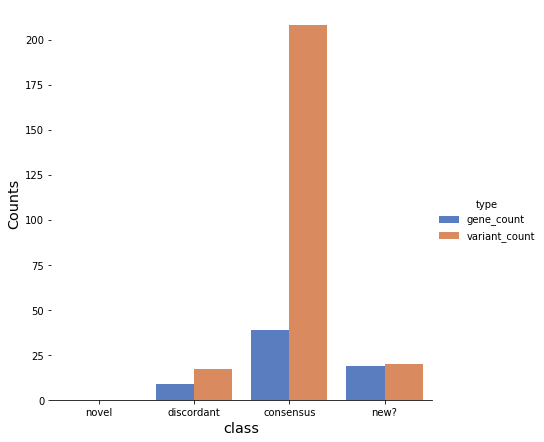

,id,chromosome,pos,cDNA_position,ref,alt,symbol,gencode_transcription_id,uniprot_ac,uniprot_position,amino_acid_residue,transcript_alt,transcript_consequence,ext_db_id,region_name,consensus_position
1210,DDD13k.09112,chr2,113950699,1913,C,T,PSD4,ENST00000245796.6,Q8NDX1,637.0,A,T,missense_variant,PF01369,Sec7 domain,81.0
2309,101979,chr1,6195315,2845,G,A,CHD5,ENST00000262450.3,Q8TDI0,948.0,R,T,missense_variant,PF00176,SNF2 family N-terminal domain,288.0
4346,70650,chr11,68848911,1633,C,A,TPCN2,ENST00000294309.3,Q8NHX9,544.0,R,A,missense_variant,PF00520,Ion transport protein,95.0
5092,74819,chr2,111399764,2395,C,T,BUB1,ENST00000302759.6,O43683,798.0,A,A,missense_variant,PF00069,Protein kinase domain,12.0
5271,49366,chr11,111473381,94,G,T,SIK2,ENST00000304987.3,Q9H0K1,31.0,A,T,missense_variant,PF00069,Protein kinase domain,12.0
6587,74385,chr14,63417240,980,C,T,KCNH5,ENST00000322893.7,Q8NCM2,326.0,R,A,missense_variant,PF00520,Ion transport protein,101.0
10244,DDD13k.06591,chr6,111136243,97,C,T,CDK19,ENST00000368911.3,Q9BWU1,32.0,G,A,missense_variant,PF00069,Protein kinase domain,12.0
10667,6011,chr9,140878675,1742,G,A,CACNA1B,ENST00000371372.1,Q00975,580.0,R,A,missense_variant,PF00520,Ion transport protein,101.0
10733,60787,chr20,49621072,1046,C,T,KCNG1,ENST00000371571.4,Q9UIX4,348.0,R,A,missense_variant,PF00520,Ion transport protein,101.0
12161,113383,chr13,41706178,470,C,T,KBTBD6,ENST00000379485.1,Q86V97,156.0,R,A,missense_variant,PF00651,BTB/POZ domain,99.0


In [13]:
# retrieve the variants that correspond to the hotspots 
# missense_at_significant_hotspot = missense_at_consensus[[p in missense_hotspots_significant.groupby(('domain_id', 'consensus_position')).groups for p in zip(missense_at_consensus['ext_db_id'], missense_at_consensus['consensus_position'])]]
missense_at_significant_hotspot = pd.DataFrame(missense_at_consensus[missense_at_consensus.ext_db_id.isin(list(pd.unique(missense_hotspots_significant_filtered.domain_id)))])
missense_at_significant_hotspot = pd.DataFrame(missense_at_significant_hotspot[[p in missense_hotspots_significant_filtered.groupby(['domain_id', 'consensus_position']).groups for p in zip(missense_at_significant_hotspot['ext_db_id'], missense_at_significant_hotspot['consensus_position'])]])


# Check in which gene list these variants are present
missense_hotspot_in_novels = missense_at_significant_hotspot[missense_at_significant_hotspot.symbol.isin(novel_genes.symbol)]
missense_hotspot_in_discordant_known = missense_at_significant_hotspot[missense_at_significant_hotspot.symbol.isin(discordant_known_genes.symbol)]
missense_hotspot_in_consensus_known = missense_at_significant_hotspot[missense_at_significant_hotspot.symbol.isin(consensus_known_genes.symbol)]
missense_hotspot_in_new = missense_at_significant_hotspot[~(missense_at_significant_hotspot.symbol.isin(consensus_known_genes.symbol)) & ~(missense_at_significant_hotspot.symbol.isin(novel_genes.symbol)) & ~(missense_at_significant_hotspot.symbol.isin(discordant_known_genes.symbol))]

# Double check thath all the variants found at the hotspots are also in the various subsets
assert len(missense_at_significant_hotspot) == (len(missense_hotspot_in_novels) + len(missense_hotspot_in_discordant_known) + len(missense_hotspot_in_consensus_known) + len(missense_hotspot_in_new))

# Input into visualization dataset
vis_data = []
vis_data.append({'class': 'novel', 'type':'gene_count', 'count':len(pd.unique(missense_hotspot_in_novels.symbol))})
vis_data.append({'class': 'novel', 'type':'variant_count', 'count':len(missense_hotspot_in_novels)})
vis_data.append({'class': 'discordant', 'type':'gene_count', 'count':len(pd.unique(missense_hotspot_in_discordant_known.symbol))})
vis_data.append({'class': 'discordant', 'type':'variant_count', 'count':len(missense_hotspot_in_discordant_known)})
vis_data.append({'class': 'consensus', 'type':'gene_count', 'count':len(pd.unique(missense_hotspot_in_consensus_known.symbol))})
vis_data.append({'class': 'consensus', 'type':'variant_count', 'count':len(missense_hotspot_in_consensus_known)})
vis_data.append({'class': 'new?', 'type':'gene_count', 'count':len(pd.unique(missense_hotspot_in_new.symbol))})
vis_data.append({'class': 'new?', 'type':'variant_count', 'count':len(missense_hotspot_in_new)})
vis_data_df = pd.DataFrame(vis_data)

# Draw a nested barplot to show survival for class and sex
g = sns.catplot(x="class", y="count", hue="type", data=vis_data_df,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Counts")

plt.show()

display(missense_hotspot_in_new[variants_with_metadomain_annotation_columns])

,id,chromosome,pos,cDNA_position,ref,alt,symbol,gencode_transcription_id,uniprot_ac,uniprot_position,amino_acid_residue,transcript_alt,transcript_consequence,ext_db_id,region_name,consensus_position
4346,70650,chr11,68848911,1633,C,A,TPCN2,ENST00000294309.3,Q8NHX9,544.0,R,A,missense_variant,PF00520,Ion transport protein,95.0
6587,74385,chr14,63417240,980,C,T,KCNH5,ENST00000322893.7,Q8NCM2,326.0,R,A,missense_variant,PF00520,Ion transport protein,101.0
10667,6011,chr9,140878675,1742,G,A,CACNA1B,ENST00000371372.1,Q00975,580.0,R,A,missense_variant,PF00520,Ion transport protein,101.0
10733,60787,chr20,49621072,1046,C,T,KCNG1,ENST00000371571.4,Q9UIX4,348.0,R,A,missense_variant,PF00520,Ion transport protein,101.0
15765,DDD13k.00186,chr11,2432929,2549,C,T,TRPM5,ENST00000452833.1,Q9NZQ8-2,849.0,R,A,missense_variant,PF00520,Ion transport protein,101.0
17074,rumc_patient_2348,chr12,113706596,794,G,A,TPCN1,ENST00000541517.1,Q9ULQ1-3,264.0,R,A,missense_variant,PF00520,Ion transport protein,95.0


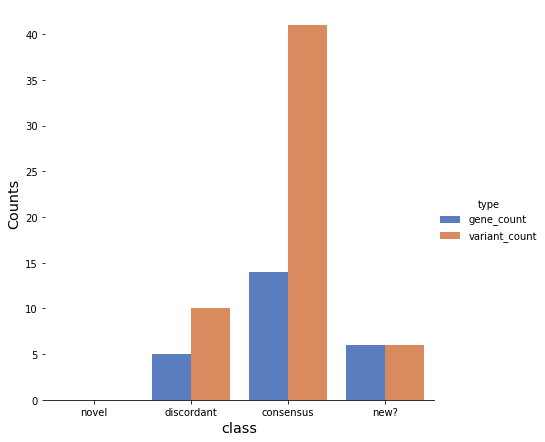

In [14]:
# retrieve the variants that correspond to the hotspots 
# missense_at_significant_unique_hotspot = missense_at_consensus[[p in missense_hotspots_significant.groupby(('domain_id', 'consensus_position')).groups for p in zip(missense_at_consensus['ext_db_id'], missense_at_consensus['consensus_position'])]]
missense_at_significant_unique_hotspot = pd.DataFrame(missense_at_consensus[missense_at_consensus.ext_db_id.isin(list(pd.unique(missense_hotspots_unique_significant_filtered.domain_id)))])
missense_at_significant_unique_hotspot = pd.DataFrame(missense_at_significant_unique_hotspot[[p in missense_hotspots_unique_significant_filtered.groupby(['domain_id', 'consensus_position']).groups for p in zip(missense_at_significant_unique_hotspot['ext_db_id'], missense_at_significant_unique_hotspot['consensus_position'])]])

# Check in which gene list these variants are present
missense_unique_hotspot_in_novels = missense_at_significant_unique_hotspot[missense_at_significant_unique_hotspot.symbol.isin(novel_genes.symbol)]
missense_unique_hotspot_in_discordant_known = missense_at_significant_unique_hotspot[missense_at_significant_unique_hotspot.symbol.isin(discordant_known_genes.symbol)]
missense_unique_hotspot_in_consensus_known = missense_at_significant_unique_hotspot[missense_at_significant_unique_hotspot.symbol.isin(consensus_known_genes.symbol)]
missense_unique_hotspot_in_new = missense_at_significant_unique_hotspot[~(missense_at_significant_unique_hotspot.symbol.isin(consensus_known_genes.symbol)) & ~(missense_at_significant_unique_hotspot.symbol.isin(novel_genes.symbol)) & ~(missense_at_significant_unique_hotspot.symbol.isin(discordant_known_genes.symbol))]

# Double check thath all the variants found at the hotspots are also in the various subsets
assert len(missense_at_significant_unique_hotspot) == (len(missense_unique_hotspot_in_novels) + len(missense_unique_hotspot_in_discordant_known) + len(missense_unique_hotspot_in_consensus_known) + len(missense_unique_hotspot_in_new))

# Input into visualization dataset
vis_data = []
vis_data.append({'class': 'novel', 'type':'gene_count', 'count':len(pd.unique(missense_unique_hotspot_in_novels.symbol))})
vis_data.append({'class': 'novel', 'type':'variant_count', 'count':len(missense_unique_hotspot_in_novels)})
vis_data.append({'class': 'discordant', 'type':'gene_count', 'count':len(pd.unique(missense_unique_hotspot_in_discordant_known.symbol))})
vis_data.append({'class': 'discordant', 'type':'variant_count', 'count':len(missense_unique_hotspot_in_discordant_known)})
vis_data.append({'class': 'consensus', 'type':'gene_count', 'count':len(pd.unique(missense_unique_hotspot_in_consensus_known.symbol))})
vis_data.append({'class': 'consensus', 'type':'variant_count', 'count':len(missense_unique_hotspot_in_consensus_known)})
vis_data.append({'class': 'new?', 'type':'gene_count', 'count':len(pd.unique(missense_unique_hotspot_in_new.symbol))})
vis_data.append({'class': 'new?', 'type':'variant_count', 'count':len(missense_unique_hotspot_in_new)})
vis_data_df = pd.DataFrame(vis_data)

# Draw a nested barplot to show survival for class and sex
g = sns.catplot(x="class", y="count", hue="type", data=vis_data_df,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Counts")

display(missense_unique_hotspot_in_new[variants_with_metadomain_annotation_columns])


In [15]:
missense_unique_hotspot_in_novels = missense_at_significant_unique_hotspot[missense_at_significant_unique_hotspot.symbol.isin(novel_genes.symbol)]
missense_unique_hotspot_in_discordant_known = missense_at_significant_unique_hotspot[missense_at_significant_unique_hotspot.symbol.isin(discordant_known_genes.symbol)]
missense_unique_hotspot_in_consensus_known = missense_at_significant_unique_hotspot[missense_at_significant_unique_hotspot.symbol.isin(consensus_known_genes.symbol)]

In [16]:
print('hotspots:')
print('Proposed Novel (joint de novo) genes with hotspots: '+str(len(pd.unique(missense_hotspot_in_novels.symbol))))
print('Discordant (joint de novo) genes with hotspots: '+str(len(pd.unique(missense_hotspot_in_discordant_known.symbol))))
print('Consensus (joint de novo) genes with hotspots: '+str(len(pd.unique(missense_hotspot_in_consensus_known.symbol))))
print('Novel? genes (based on hotspots): '+str(len(pd.unique(missense_hotspot_in_new.symbol))))
print('Total genes with hotspots: '+str(len(pd.unique(missense_at_significant_hotspot.symbol))))
print('Total missense at these hotspots: '+str(len(missense_at_significant_hotspot)))
print('Total missense at hotspots in the novel genes: '+str(len(missense_hotspot_in_new)))
print()
print('Unique hotspots')
print('Proposed Novel (joint de novo) genes with hotspots: '+str(len(pd.unique(missense_unique_hotspot_in_novels.symbol))))
print('Discordant (joint de novo) genes with hotspots: '+str(len(pd.unique(missense_unique_hotspot_in_discordant_known.symbol))))
print('Consensus (joint de novo) genes with hotspots: '+str(len(pd.unique(missense_unique_hotspot_in_consensus_known.symbol))))
print('Novel? genes (based on hotspots): '+str(len(pd.unique(missense_unique_hotspot_in_new.symbol))))
print('Total genes with hotspots: '+str(len(pd.unique(missense_at_significant_unique_hotspot.symbol))))
print('Total missense at these hotspots: '+str(len(missense_at_significant_unique_hotspot)))
print('Total missense at hotspots in the novel genes: '+str(len(missense_unique_hotspot_in_new)))

hotspots:
Proposed Novel (joint de novo) genes with hotspots: 0
Discordant (joint de novo) genes with hotspots: 9
Consensus (joint de novo) genes with hotspots: 39
Novel? genes (based on hotspots): 19
Total genes with hotspots: 67
Total missense at these hotspots: 245
Total missense at hotspots in the novel genes: 20

Unique hotspots
Proposed Novel (joint de novo) genes with hotspots: 0
Discordant (joint de novo) genes with hotspots: 5
Consensus (joint de novo) genes with hotspots: 14
Novel? genes (based on hotspots): 6
Total genes with hotspots: 25
Total missense at these hotspots: 57
Total missense at hotspots in the novel genes: 6


In [17]:
pd.unique(missense_unique_hotspot_in_new.symbol)

array(['TPCN2', 'KCNH5', 'CACNA1B', 'KCNG1', 'TRPM5', 'TPCN1'],
      dtype=object)

## Are missense DNM hotspots more likely located in DD-associated genes?

In [18]:
def contingency_table_hotspot_dd_genes(x_hotspot_ID, y_hotspot_new, x_not_hotspot_id, y_not_hotspot_new, correction=1):
    # Construct into a contigency table
    names = []
    c_table = []
    mosaic_plot_c_table = {}

    # Describe the contigency table different for the mosaic plot
    c_table.append([x_hotspot_ID, x_not_hotspot_id])
    mosaic_plot_c_table[('known_ID', 'with_hotspot')] = x_hotspot_ID
    mosaic_plot_c_table[('known_ID', 'without_hotspot')] = x_not_hotspot_id
    c_table.append([y_hotspot_new, y_not_hotspot_new])
    mosaic_plot_c_table[('not_ID', 'with_hotspot')] = y_hotspot_new
    mosaic_plot_c_table[('not_ID', 'without_hotspot')] = y_not_hotspot_new

    c_table = np.array(c_table)
    c_table_df = pd.DataFrame(c_table, index=['known_ID', 'not_ID'], columns=['with_hotspot', 'without_hotspot'])

    g, pvalue, dof, expctd = scs.chi2_contingency(c_table, lambda_="log-likelihood")
    corrected_pvalue = np.minimum((pvalue*correction), 1.0)

    # Append data from this check to the table_dataframe
    c_table_df['percentage_in_hotspot'] = np.round((c_table_df.with_hotspot/(c_table_df.with_hotspot+c_table_df.without_hotspot)*100),2)

    # report the statistics
    print("Contingency table:")
    display(c_table_df)
    print("p-value = "+str(corrected_pvalue)+" (Correction: N="+str(correction)+")\ttest statistic = "+str(g)+"\tdegrees of freedom = "+str(dof))
    print("DD-associated genes with significant hotspot is enriched by a "+str(x_hotspot_ID/y_hotspot_new)+" fold")
    print()

    # Create a mosaic plot
    from statsmodels.graphics.mosaicplot import mosaic
    mosaic(mosaic_plot_c_table, gap=0.01)
    plt.show()

### Lenient counts

Contingency table:


,with_hotspot,without_hotspot,percentage_in_hotspot
known_ID,48,567,7.80
not_ID,19,4985,0.38


p-value = 1.258198284260153e-31 (Correction: N=1)	test statistic = 136.91561677918418	degrees of freedom = 1
DD-associated genes with significant hotspot is enriched by a 2.526315789473684 fold



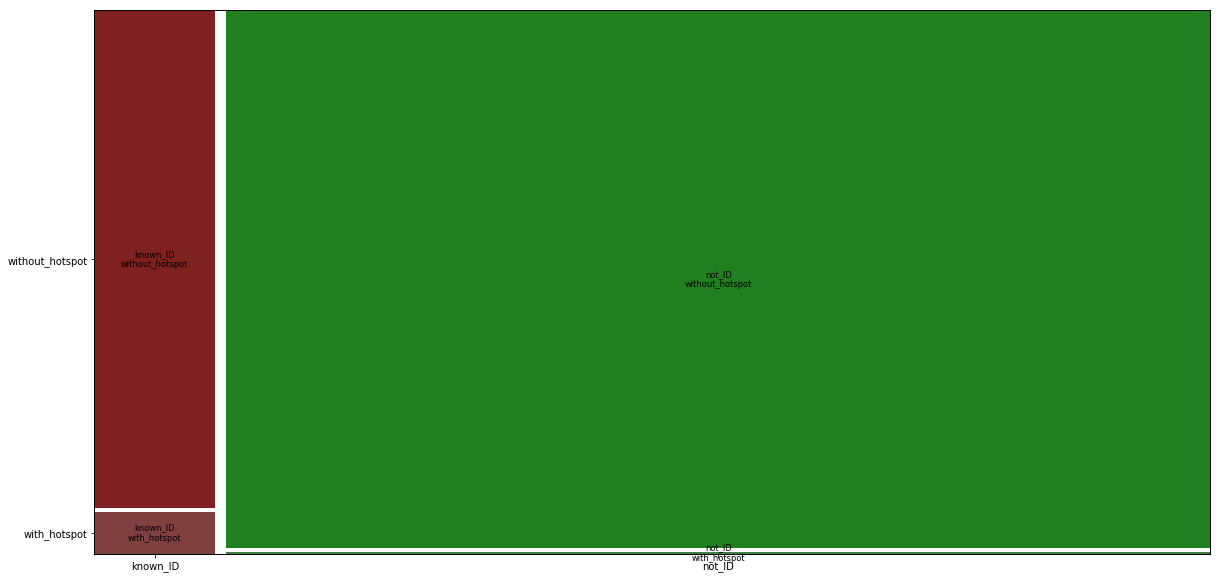

In [19]:
# First divide all genes in hotspot analyses as DD-associated and not DD-associated
all_tested_genes = list(pd.unique(missense_at_consensus.symbol))
all_tested_dd_genes = [x for x in all_tested_genes if x in list(pd.unique(novel_genes.symbol)) or x in list(pd.unique(discordant_known_genes.symbol)) or x in list(pd.unique(consensus_known_genes.symbol))]
all_tested_not_known_dd_genes = [x for x in all_tested_genes if x not in all_tested_dd_genes]
assert len(all_tested_dd_genes) + len(all_tested_not_known_dd_genes) == len(all_tested_genes)

# Secondly, divide the genes with  significant hotspot in DD-associated and not DD-associated
hotspot_not_known_dd_genes = list(pd.unique(missense_hotspot_in_new.symbol))
hotspot_known_genes = list(pd.unique(missense_hotspot_in_novels.symbol))+list(pd.unique(missense_hotspot_in_discordant_known.symbol))+list(pd.unique(missense_hotspot_in_consensus_known.symbol))
assert len(hotspot_not_known_dd_genes) + len(hotspot_known_genes) == len(list(pd.unique(missense_at_significant_hotspot.symbol)))

# Thirdly, divide DD-associated genes and not DD-associated genes into those with or without a significant hotspot
no_hotspot_not_known_dd_genes = [x for x in all_tested_not_known_dd_genes if x not in hotspot_not_known_dd_genes]
no_hotspot_known_dd_genes = [x for x in all_tested_dd_genes if x not in hotspot_known_genes]
assert len(no_hotspot_not_known_dd_genes) == len(all_tested_not_known_dd_genes) - len(hotspot_not_known_dd_genes)
assert len(no_hotspot_known_dd_genes) == len(all_tested_dd_genes) - len(hotspot_known_genes)
assert len(all_tested_genes) == len(hotspot_known_genes)+len(hotspot_not_known_dd_genes)+len(no_hotspot_known_dd_genes)+len(no_hotspot_not_known_dd_genes)

contingency_table_hotspot_dd_genes(x_hotspot_ID = len(hotspot_known_genes),\
                                   y_hotspot_new = len(hotspot_not_known_dd_genes),\
                                   x_not_hotspot_id = len(no_hotspot_known_dd_genes),\
                                   y_not_hotspot_new = len(no_hotspot_not_known_dd_genes))



### Unique counts

Contingency table:


,with_hotspot,without_hotspot,percentage_in_hotspot
known_ID,19,596,3.09
not_ID,6,4998,0.12


p-value = 1.1066163079523613e-13 (Correction: N=1)	test statistic = 55.16789393986804	degrees of freedom = 1
DD-associated genes with significant hotspot is enriched by a 3.1666666666666665 fold



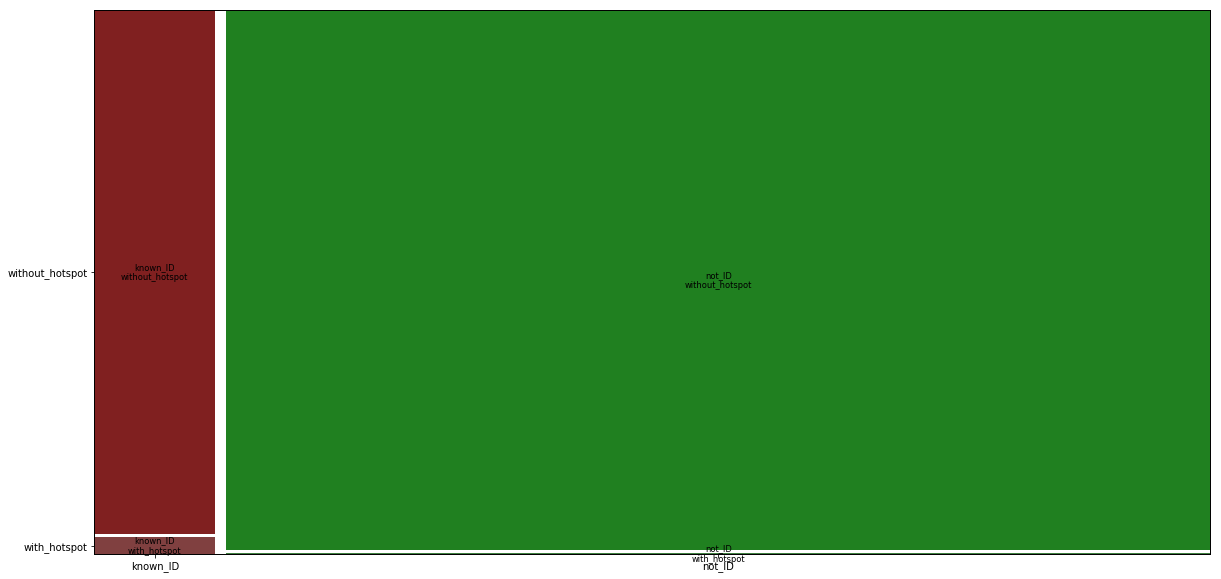

In [20]:
# First divide all genes in hotspot analyses as DD-associated and not DD-associated
all_tested_genes = list(pd.unique(missense_at_consensus.symbol))
all_tested_dd_genes = [x for x in all_tested_genes if x in list(pd.unique(novel_genes.symbol)) or x in list(pd.unique(discordant_known_genes.symbol)) or x in list(pd.unique(consensus_known_genes.symbol))]
all_tested_not_known_dd_genes = [x for x in all_tested_genes if x not in all_tested_dd_genes]
assert len(all_tested_dd_genes) + len(all_tested_not_known_dd_genes) == len(all_tested_genes)

# Secondly, divide the genes with  significant hotspot in DD-associated and not DD-associated
hotspot_not_known_dd_genes = list(pd.unique(missense_unique_hotspot_in_new.symbol))
hotspot_known_genes = list(pd.unique(missense_unique_hotspot_in_novels.symbol))+list(pd.unique(missense_unique_hotspot_in_discordant_known.symbol))+list(pd.unique(missense_unique_hotspot_in_consensus_known.symbol))
assert len(hotspot_not_known_dd_genes) + len(hotspot_known_genes) == len(list(pd.unique(missense_at_significant_unique_hotspot.symbol)))

# Thirdly, divide DD-associated genes and not DD-associated genes into those with or without a significant hotspot
no_hotspot_not_known_dd_genes = [x for x in all_tested_not_known_dd_genes if x not in hotspot_not_known_dd_genes]
no_hotspot_known_dd_genes = [x for x in all_tested_dd_genes if x not in hotspot_known_genes]
assert len(no_hotspot_not_known_dd_genes) == len(all_tested_not_known_dd_genes) - len(hotspot_not_known_dd_genes)
assert len(no_hotspot_known_dd_genes) == len(all_tested_dd_genes) - len(hotspot_known_genes)
assert len(all_tested_genes) == len(hotspot_known_genes)+len(hotspot_not_known_dd_genes)+len(no_hotspot_known_dd_genes)+len(no_hotspot_not_known_dd_genes)

contingency_table_hotspot_dd_genes(x_hotspot_ID = len(hotspot_known_genes),\
                                   y_hotspot_new = len(hotspot_not_known_dd_genes),\
                                   x_not_hotspot_id = len(no_hotspot_known_dd_genes),\
                                   y_not_hotspot_new = len(no_hotspot_not_known_dd_genes))

# Domain PF00520 hotspots in context (main fig)

Domain PF00520
Consensus length: 245
Total variants (n_adj): 350
Variants needed for significance on hotspot: 10 (corrected for 2032 domain families)


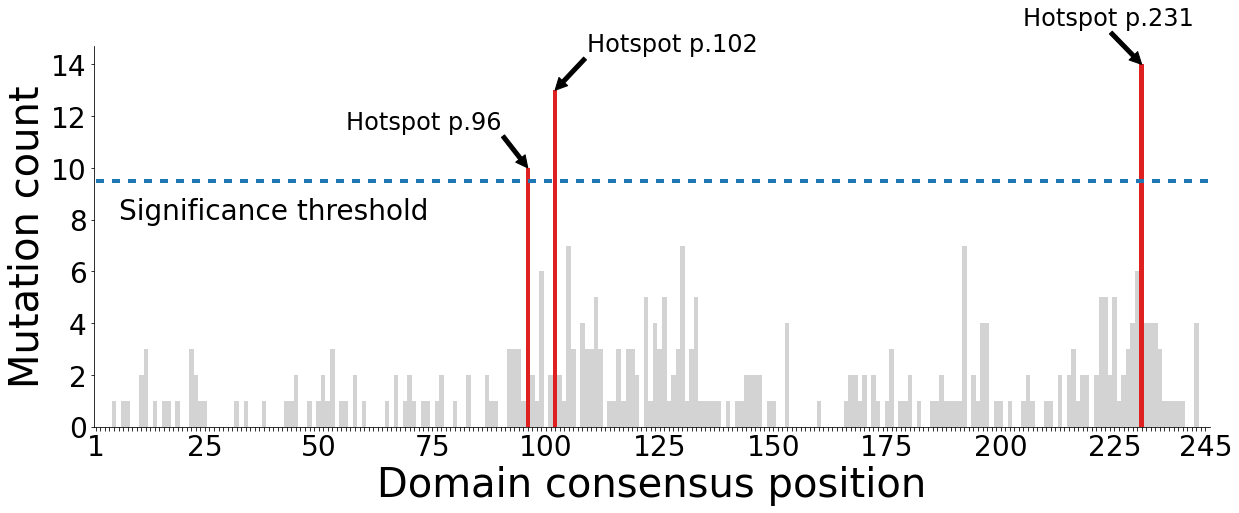

In [21]:
# Retrieve domain length
domain_consensus_length = metadomain_details_df[metadomain_details_df.domain_id=='PF00520'].consensus_length.iloc[0] 

# Retrieve correction used for number of domain families
n_domain_correction = len(pd.unique(filter_variants_to_transcript_consequence(filtered_variants, 'missense_variant').ext_db_id))

# Retrieve summation of al variants in this domain
n_adj= missense_hotspots_candidates[missense_hotspots_candidates.ext_db_id == 'PF00520']['n_variants_unique_count_method'].sum()

# Compute minimal number of variants that needs to be on a single location to be significant
minimum_variants = 0
for i in range(1,n_adj):
    minimum_variants = i
    p_value_alt, probability_alt, m_cluster_score_alt = MetaDomainHotSpotScoring(minimum_variants, n_adj, domain_consensus_length)
    p_value_alt_cor = p_value_alt*n_domain_correction
    if p_value_alt_cor < 0.05:
        break

# Print out details of this domain
print("Domain PF00520")
print("Consensus length: "+str(domain_consensus_length))
print("Total variants (n_adj): "+str(n_adj))
print("Variants needed for significance on hotspot: "+str(minimum_variants)+" (corrected for "+str(n_domain_correction)+" domain families)")
        
# Generate data for graph, fill in missing values
pf00520_data = pd.DataFrame(missense_hotspots_candidates[missense_hotspots_candidates.ext_db_id == 'PF00520'])
pf00520_data["consensus_position"] = pf00520_data["consensus_position"].astype(int)+1

to_be_added =[]
for i in range(1,domain_consensus_length+1):
    if len(pf00520_data[pf00520_data["consensus_position"]==i])==0:
        to_be_added.append({'consensus_position':i, 'ext_db_id':"PF00520", 'hotspot_uniqueness':0.0, 'n_original_variants':0, 'n_variants_count_method':0, 'n_variants_per_protein_position':0, 'n_variants_unique_count_method':0})

pf00520_data = pf00520_data.append(pd.DataFrame(to_be_added), ignore_index=True)
pf00520_data = pf00520_data.sort_values('consensus_position')

## Draw the plot
fig, ax = plt.subplots(figsize=(20,7))

# Define bar colors
bar_colors = ['lightgrey' if not (x in [96,102,231]) else 'red' for x in range(1,domain_consensus_length+1) ]

# Draw the main plot
sns.barplot(x="consensus_position", y="n_variants_unique_count_method", data=pf00520_data, palette=bar_colors, edgecolor="none")

## Annotations
# Signigicance treshold
sns.lineplot(x=range(0,domain_consensus_length+1),  linewidth=4,  y=9.5, style=True, dashes=[(2, 2)], legend=False)
ax.annotate('Significance threshold', xy=(5, 10), xytext=(5, 8), fontsize=28);

# Hotspot text
ax.annotate('Hotspot p.96', fontsize=24, xy=(95, 10), xytext=(55, 11.5), arrowprops=dict(facecolor='black'))
ax.annotate('Hotspot p.102', fontsize=24, xy=(101, 13), xytext=(108, 14.5), arrowprops=dict(facecolor='black'))
ax.annotate('Hotspot p.231', fontsize=24, xy=(230, 14), xytext=(204, 15.5), arrowprops=dict(facecolor='black'))

# Change tick labels
plt.yticks(fontsize=28)
plt.xticks(fontsize=28)
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if (n+1) % 25 != 0:
        label.set_visible(False)
    if n == 0 or n == domain_consensus_length-1:
        label.set_visible(True)

# Add y and x label
plt.ylabel("Mutation count", fontsize=40)
plt.xlabel("Domain consensus position", fontsize=40)

## Tidying up
# remove the frames
sns.despine()
plt.gca().margins(x=0)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

# change the width between axis
change_width(ax, 1)

# Save the plot
fig.savefig('../results/PF00520_unique_variants_per_location.svg')

## Save the data to disk

In [22]:
### Save the in and output for both the lenient and unique counts to disk
missense_hotspots_results.to_csv('../results/missense_hotspots_results.csv', index=False)
synonymous_hotspots_results.to_csv('../results/synonymous_hotspots_results.csv', index=False)
nonsense_hotspots_results.to_csv('../results/nonsense_hotspots_results.csv', index=False)

### variants found at the significant hot spot locations
## Count method
# Specify file name
variants_at_significant_count_hotspots_filename = "../results/variants_at_lenient_count_significant_hotspots.csv"
# annotate the gene list
missense_at_significant_hotspot['corresponding_diagnostic_list'] = missense_at_significant_hotspot.apply(lambda x: 'joint_de_novo_novel' if x.symbol in list(novel_genes.symbol) else 'joint_de_novo_discordant' if x.symbol in list(discordant_known_genes.symbol) else 'joint_de_novo_consensus' if x.symbol in list(consensus_known_genes.symbol) else 'new?', axis=1)
# save to disk
missense_at_significant_hotspot[['corresponding_diagnostic_list'] + variants_with_metadomain_annotation_columns].to_csv(variants_at_significant_count_hotspots_filename, index=False) 

## Unique count method
# Specify file name
variants_at_significant_unique_count_hotspots_filename = "../results/variants_at_unique_count_significant_hotspots.csv"
# annotate the gene list
missense_at_significant_unique_hotspot['corresponding_diagnostic_list'] = missense_at_significant_unique_hotspot.apply(lambda x: 'joint_de_novo_novel' if x.symbol in list(novel_genes.symbol) else 'joint_de_novo_discordant' if x.symbol in list(discordant_known_genes.symbol) else 'joint_de_novo_consensus' if x.symbol in list(consensus_known_genes.symbol) else 'new?', axis=1)
# save to disk
missense_at_significant_unique_hotspot[['corresponding_diagnostic_list'] + variants_with_metadomain_annotation_columns].to_csv(variants_at_significant_unique_count_hotspots_filename, index=False) 

### variants for the patients that have a variant at a significant hot spot location
## Count method
# Specify file name
all_variants_from_samples_identified_by_count_method_filename = "../results/all_variants_from_samples_identified_by_lenient_count_method.csv"
sample_ids_new_count_method = []
for index, row in missense_hotspot_in_new.iterrows():
    sample_ids_new_count_method.append(row.id)

# retrieve the list of variants found in these patients
all_variants_from_samples_identified_by_count_method = de_novos_annotated_filtered[(de_novos_annotated_filtered.id.isin(sample_ids_new_count_method))]

# annotate the gene list
all_variants_from_samples_identified_by_count_method['corresponding_diagnostic_list'] = all_variants_from_samples_identified_by_count_method.apply(lambda x: 'joint_de_novo_novel' if x.symbol in list(novel_genes.symbol) else 'joint_de_novo_discordant' if x.symbol in list(discordant_known_genes.symbol) else 'joint_de_novo_consensus' if x.symbol in list(consensus_known_genes.symbol) else '', axis=1)
for index, row in missense_hotspot_in_new.iterrows():
    all_variants_from_samples_identified_by_count_method.corresponding_diagnostic_list[(row.id == all_variants_from_samples_identified_by_count_method.id) & (row.pos == all_variants_from_samples_identified_by_count_method.pos)] = 'new?'

# save to disk
all_variants_from_samples_identified_by_count_method[['corresponding_diagnostic_list'] + de_novo_variants_columns].to_csv(all_variants_from_samples_identified_by_count_method_filename, index=False) 

## Unique count method
# Specify file name
all_variants_from_samples_identified_by_unique_count_method_filename = "../results/all_variants_from_samples_identified_by_unique_count_method.csv"
sample_ids_new_unique_count_method = []
for index, row in missense_unique_hotspot_in_new.iterrows():
    sample_ids_new_unique_count_method.append(row.id)

# retrieve the list of variants found in these patients
all_variants_from_samples_identified_by_unique_count_method = de_novos_annotated_filtered[(de_novos_annotated_filtered.id.isin(sample_ids_new_unique_count_method))]

# annotate the gene list
all_variants_from_samples_identified_by_unique_count_method['corresponding_diagnostic_list'] = all_variants_from_samples_identified_by_unique_count_method.apply(lambda x: 'joint_de_novo_novel' if x.symbol in list(novel_genes.symbol) else 'joint_de_novo_discordant' if x.symbol in list(discordant_known_genes.symbol) else 'joint_de_novo_consensus' if x.symbol in list(consensus_known_genes.symbol) else '', axis=1)
for index, row in missense_unique_hotspot_in_new.iterrows():
    all_variants_from_samples_identified_by_unique_count_method.corresponding_diagnostic_list[(row.id == all_variants_from_samples_identified_by_unique_count_method.id) & (row.pos == all_variants_from_samples_identified_by_unique_count_method.pos)] = 'new?'

# save to disk
all_variants_from_samples_identified_by_unique_count_method[['corresponding_diagnostic_list'] + de_novo_variants_columns].to_csv(all_variants_from_samples_identified_by_unique_count_method_filename, index=False) 


### variants found in the remainder of the genes that have variants at a hot spot
## Count method
# specify file name
all_variants_from_candidate_genes_identified_by_count_method_filename = "../results/all_variants_from_candidate_genes_identified_by_lenient_count_method.csv"
all_variants_from_candidate_genes_identified_by_count_method = de_novos_annotated_filtered[(de_novos_annotated_filtered.symbol.isin(missense_hotspot_in_new.symbol))]
# annotate the gene list
all_variants_from_candidate_genes_identified_by_count_method['hot_spot'] = "No"
for index, row in missense_hotspot_in_new.iterrows():
    all_variants_from_candidate_genes_identified_by_count_method.hot_spot[(row.id == all_variants_from_candidate_genes_identified_by_count_method.id) & (row.pos == all_variants_from_candidate_genes_identified_by_count_method.pos)] = 'yes'
# save to disk
all_variants_from_candidate_genes_identified_by_count_method[['hot_spot'] + de_novo_variants_columns].to_csv(all_variants_from_candidate_genes_identified_by_count_method_filename, index=False) 


# Unique count method
all_variants_from_candidate_genes_identified_by_unique_count_method_filename = "../results/all_variants_from_candidate_genes_identified_by_unique_count_method.csv"
all_variants_from_candidate_genes_identified_by_unique_count_method = de_novos_annotated_filtered[(de_novos_annotated_filtered.symbol.isin(missense_unique_hotspot_in_new.symbol))]
# annotate the gene list
all_variants_from_candidate_genes_identified_by_unique_count_method['hot_spot'] = "No"
for index, row in missense_unique_hotspot_in_new.iterrows():
    all_variants_from_candidate_genes_identified_by_unique_count_method.hot_spot[(row.id == all_variants_from_candidate_genes_identified_by_unique_count_method.id) & (row.pos == all_variants_from_candidate_genes_identified_by_unique_count_method.pos)] = 'yes'
# save to disk
all_variants_from_candidate_genes_identified_by_unique_count_method[['hot_spot'] + de_novo_variants_columns].to_csv(all_variants_from_candidate_genes_identified_by_unique_count_method_filename, index=False) 


/tmp/ipykernel_173/1837557549.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_variants_from_samples_identified_by_count_method['corresponding_diagnostic_list'] = all_variants_from_samples_identified_by_count_method.apply(lambda x: 'joint_de_novo_novel' if x.symbol in list(novel_genes.symbol) else 'joint_de_novo_discordant' if x.symbol in list(discordant_known_genes.symbol) else 'joint_de_novo_consensus' if x.symbol in list(consensus_known_genes.symbol) else '', axis=1)
/tmp/ipykernel_173/1837557549.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all